# IMDB Datasets

**Purpose:**

Working with "big" data in PySpark

**Data Source:**
    
https://datasets.imdbws.com

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:90% !important; font-size:100%;}</style>"))
display(HTML("<style>div.output_area pre {white-space: pre;}</style>"))

In [2]:
import sys

print('Python info', sys.version)

Python info 3.8.3 (default, Jul  2 2020, 16:21:59) 
[GCC 7.3.0]


In [3]:
import os

print('This is the curent directory', os.getcwd())

This is the curent directory /home/gda/Documents/github/ppforde/python/imdb


In [4]:
import datetime

current_date = datetime.date.today()
current_time = datetime.datetime.now()

print("System date/time", current_time)
print('Current date', datetime.datetime.strftime(current_date, '%A %m/%d/%Y'))
print('Current time', datetime.datetime.strftime(current_time, '%I:%M:%S %p'))

System date/time 2021-12-23 12:04:27.233520
Current date Thursday 12/23/2021
Current time 12:04:27 PM


In [5]:
1728766import requests
from bs4 import BeautifulSoup

from pprint import pprint
import re

In [6]:
from pyspark.sql import SparkSession, Row
from pyspark.context import SparkContext
from pyspark.sql.functions import *
from pyspark.sql.types import *

In [7]:
spark = SparkSession.builder.appName("Spark SQL Query Dataframes").getOrCreate()
spark

In [8]:
1728766#spark = SparkSession.builder.appName("IMDB_Movies")\
#.config("spark.sql.shuffle.partitions", "50")\
#.config("spark.driver.maxResultSize", "5g")\
#.config("Spark.sql.execution.arrow.enabled", "true")\
#.getOrCreate()

#spark

In [9]:
sc = spark.sparkContext

In [10]:
!pip install wget

In [11]:
import wget

import gzip
import shutil
import csv

In [12]:
URL = "https://datasets.imdbws.com/title.basics.tsv.gz"

In [13]:
print(URL)

https://datasets.imdbws.com/title.basics.tsv.gz


In [14]:
filename = wget.download(URL)

In [15]:
print(filename)

title.basics.tsv.gz


In [16]:
with gzip.open(filename, mode='r') as f_in, open(filename.replace('.gz',''), mode='wb') as f_out:
    shutil.copyfileobj(f_in, f_out)
    
uncompressed_file = filename.replace('.gz','')

print(uncompressed_file)

title.basics.tsv


In [17]:
1728766# JSON
#df = sc.read.json('fp.json')

# TXT
#df = sc.read.text('fp.txt')

# CSV
#df = sc.read_csv('fp.csv')

In [18]:
spark_df0 = spark.read.format("csv")\
    .option("header","true")\
    .option("sep","\t")\
    .option("encoding","utf-8")\
    .option("nullValues", r"\N")\
    .option("quote","")\
    .option("inferSchema","true")\
    .load(uncompressed_file)

spark_df0.show(truncate=False)

+---------+---------+-------------------------------------------+-------------------------------------------------+-------+---------+-------+--------------+------------------------+
|tconst   |titleType|primaryTitle                               |originalTitle                                    |isAdult|startYear|endYear|runtimeMinutes|genres                  |
+---------+---------+-------------------------------------------+-------------------------------------------------+-------+---------+-------+--------------+------------------------+
|tt0000001|short    |Carmencita                                 |Carmencita                                       |0      |1894     |\N     |1             |Documentary,Short       |
|tt0000002|short    |Le clown et ses chiens                     |Le clown et ses chiens                           |0      |1892     |\N     |5             |Animation,Short         |
|tt0000003|short    |Pauvre Pierrot                             |Pauvre Pierrot           

In [19]:
spark_df0.printSchema()

root
 |-- tconst: string (nullable = true)
 |-- titleType: string (nullable = true)
 |-- primaryTitle: string (nullable = true)
 |-- originalTitle: string (nullable = true)
 |-- isAdult: integer (nullable = true)
 |-- startYear: string (nullable = true)
 |-- endYear: string (nullable = true)
 |-- runtimeMinutes: string (nullable = true)
 |-- genres: string (nullable = true)



In [20]:
spark_df0.dtypes

[('tconst', 'string'),
 ('titleType', 'string'),
 ('primaryTitle', 'string'),
 ('originalTitle', 'string'),
 ('isAdult', 'int'),
 ('startYear', 'string'),
 ('endYear', 'string'),
 ('runtimeMinutes', 'string'),
 ('genres', 'string')]

In [21]:
spark_df0.columns

['tconst',
 'titleType',
 'primaryTitle',
 'originalTitle',
 'isAdult',
 'startYear',
 'endYear',
 'runtimeMinutes',
 'genres']

In [22]:
spark_df0.head()

Row(tconst='tt0000001', titleType='short', primaryTitle='Carmencita', originalTitle='Carmencita', isAdult=0, startYear='1894', endYear='\\N', runtimeMinutes='1', genres='Documentary,Short')

In [23]:
spark_df0.take(15)

[Row(tconst='tt0000001', titleType='short', primaryTitle='Carmencita', originalTitle='Carmencita', isAdult=0, startYear='1894', endYear='\\N', runtimeMinutes='1', genres='Documentary,Short'),
 Row(tconst='tt0000002', titleType='short', primaryTitle='Le clown et ses chiens', originalTitle='Le clown et ses chiens', isAdult=0, startYear='1892', endYear='\\N', runtimeMinutes='5', genres='Animation,Short'),
 Row(tconst='tt0000003', titleType='short', primaryTitle='Pauvre Pierrot', originalTitle='Pauvre Pierrot', isAdult=0, startYear='1892', endYear='\\N', runtimeMinutes='4', genres='Animation,Comedy,Romance'),
 Row(tconst='tt0000004', titleType='short', primaryTitle='Un bon bock', originalTitle='Un bon bock', isAdult=0, startYear='1892', endYear='\\N', runtimeMinutes='12', genres='Animation,Short'),
 Row(tconst='tt0000005', titleType='short', primaryTitle='Blacksmith Scene', originalTitle='Blacksmith Scene', isAdult=0, startYear='1893', endYear='\\N', runtimeMinutes='1', genres='Comedy,Shor

In [24]:
spark_df0.groupBy(['isAdult','titleType']).count().sort(['isAdult','titleType']).show()

+-------+------------+-------+
|isAdult|   titleType|  count|
+-------+------------+-------+
|      0|       movie| 588132|
|      0|       short| 845951|
|      0|   tvEpisode|6215433|
|      0|tvMiniSeries|  41032|
|      0|     tvMovie| 134052|
|      0|     tvPilot|      2|
|      0|    tvSeries| 216301|
|      0|     tvShort|  10418|
|      0|   tvSpecial|  35314|
|      0|       video| 162180|
|      0|   videoGame|  29815|
|      1|       movie|   9095|
|      1|       short|   1585|
|      1|   tvEpisode| 156208|
|      1|tvMiniSeries|    194|
|      1|     tvMovie|     96|
|      1|    tvSeries|   1960|
|      1|     tvShort|      4|
|      1|   tvSpecial|     20|
|      1|       video|  93692|
+-------+------------+-------+
only showing top 20 rows



In [25]:
spark_df0 = spark_df0.filter((spark_df0["isAdult"]!=1) & (spark_df0["titleType"] == 'movie'))

In [26]:
spark_df0.groupBy(['isAdult','titleType']).count().sort(['isAdult','titleType']).show()

+-------+---------+------+
|isAdult|titleType| count|
+-------+---------+------+
|      0|    movie|588132|
+-------+---------+------+



In [27]:
URL = "https://datasets.imdbws.com/title.ratings.tsv.gz"
filename = wget.download(URL)

In [28]:
with gzip.open(filename, mode='r') as f_in, open(filename.replace('.gz',''), mode='wb') as f_out:
    shutil.copyfileobj(f_in, f_out)
    
uncompressed_file = filename.replace('.gz','')

print(uncompressed_file)

title.ratings.tsv


In [29]:
spark_df1 = spark.read.format("csv")\
    .option("header","true")\
    .option("sep","\t")\
    .option("encoding","utf-8")\
    .option("nullValues", r"\N")\
    .option("quote","")\
    .option("inferSchema","true")\
    .load(uncompressed_file)

spark_df1.show()

+---------+-------------+--------+
|   tconst|averageRating|numVotes|
+---------+-------------+--------+
|tt0000001|          5.7|    1847|
|tt0000002|          6.0|     236|
|tt0000003|          6.5|    1607|
|tt0000004|          6.0|     153|
|tt0000005|          6.2|    2430|
|tt0000006|          5.2|     158|
|tt0000007|          5.4|     761|
|tt0000008|          5.5|    1993|
|tt0000009|          5.9|     191|
|tt0000010|          6.9|    6643|
|tt0000011|          5.2|     335|
|tt0000012|          7.5|   11396|
|tt0000013|          5.8|    1758|
|tt0000014|          7.1|    5111|
|tt0000015|          6.2|     970|
|tt0000016|          5.9|    1356|
|tt0000017|          4.6|     298|
|tt0000018|          5.3|     548|
|tt0000019|          5.3|      29|
|tt0000020|          5.0|     321|
+---------+-------------+--------+
only showing top 20 rows



In [30]:
spark_df1.printSchema()

root
 |-- tconst: string (nullable = true)
 |-- averageRating: double (nullable = true)
 |-- numVotes: integer (nullable = true)



In [31]:
spark_df = spark_df0.join(spark_df1, on='tconst', how='inner')

In [32]:
spark_df.show(truncate=False)

+---------+---------+-------------------------------------------+-------------------------------------------+-------+---------+-------+--------------+---------------------------+-------------+--------+
|tconst   |titleType|primaryTitle                               |originalTitle                              |isAdult|startYear|endYear|runtimeMinutes|genres                     |averageRating|numVotes|
+---------+---------+-------------------------------------------+-------------------------------------------+-------+---------+-------+--------------+---------------------------+-------------+--------+
|tt0000862|movie    |Faldgruben                                 |Faldgruben                                 |0      |1909     |\N     |\N            |\N                         |5.1          |16      |
|tt0000941|movie    |Locura de amor                             |Locura de amor                             |0      |1909     |\N     |\N            |Drama                      |4.8          |

In [33]:
spark_df.createOrReplaceTempView('imdb_data')

In [34]:
spark.sql("SELECT * FROM imdb_data LIMIT 10").show(truncate=False)

+---------+---------+-------------------------------------------+-------------------------------------------+-------+---------+-------+--------------+-----------------------+-------------+--------+
|tconst   |titleType|primaryTitle                               |originalTitle                              |isAdult|startYear|endYear|runtimeMinutes|genres                 |averageRating|numVotes|
+---------+---------+-------------------------------------------+-------------------------------------------+-------+---------+-------+--------------+-----------------------+-------------+--------+
|tt0000862|movie    |Faldgruben                                 |Faldgruben                                 |0      |1909     |\N     |\N            |\N                     |5.1          |16      |
|tt0000941|movie    |Locura de amor                             |Locura de amor                             |0      |1909     |\N     |\N            |Drama                  |4.8          |23      |
|tt0001112

In [35]:
spark.sql("SELECT titleType, startYear, count(*) totals FROM imdb_data GROUP BY titleType, startYear ORDER BY 1, 2").show(truncate=False)

+---------+---------+------+
|titleType|startYear|totals|
+---------+---------+------+
|movie    |1896     |1     |
|movie    |1897     |1     |
|movie    |1899     |2     |
|movie    |1900     |2     |
|movie    |1901     |1     |
|movie    |1902     |1     |
|movie    |1903     |1     |
|movie    |1904     |1     |
|movie    |1905     |9     |
|movie    |1906     |9     |
|movie    |1907     |13    |
|movie    |1908     |15    |
|movie    |1909     |37    |
|movie    |1910     |46    |
|movie    |1911     |46    |
|movie    |1912     |45    |
|movie    |1913     |93    |
|movie    |1914     |171   |
|movie    |1915     |207   |
|movie    |1916     |254   |
+---------+---------+------+
only showing top 20 rows



In [36]:
stmt = \
"""
SELECT tconst, titleType, primaryTitle, startYear, runtimeMinutes, averageRating, numVotes
FROM imdb_data
WHERE primaryTitle LIKE '%Star Wars%'
"""

spark.sql(stmt).show()

+----------+---------+--------------------+---------+--------------+-------------+--------+
|    tconst|titleType|        primaryTitle|startYear|runtimeMinutes|averageRating|numVotes|
+----------+---------+--------------------+---------+--------------+-------------+--------+
| tt0121766|    movie|Star Wars: Episod...|     2005|           140|          7.5|  745800|
| tt0086190|    movie|Star Wars: Episod...|     1983|           131|          8.3|  997765|
| tt0387563|    movie|    Saving Star Wars|     2004|           117|          5.2|     124|
| tt0121765|    movie|Star Wars: Episod...|     2002|           142|          6.5|  673032|
| tt0080684|    movie|Star Wars: Episod...|     1980|           124|          8.7| 1219929|
| tt0313990|    movie|Doraemon: Nobita'...|     1985|            98|          7.2|     335|
| tt0120915|    movie|Star Wars: Episod...|     1999|           136|          6.5|  763700|
| tt0076759|    movie|Star Wars: Episod...|     1977|           121|          8.

In [37]:
stmt = """
SELECT *
FROM imdb_data
WHERE
    titleType = 'movie' AND
    averageRating > 9 AND
    genres != '\\N' AND
    numVotes > 1000
ORDER BY
    averageRating DESC
"""

spark.sql(stmt).show(25)

+----------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+-------------+--------+
|    tconst|titleType|        primaryTitle|       originalTitle|isAdult|startYear|endYear|runtimeMinutes|              genres|averageRating|numVotes|
+----------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+-------------+--------+
|tt16228146|    movie|  Oru Canadian Diary|  Oru Canadian Diary|      0|     2021|     \N|           128|            Thriller|         10.0|    2408|
|tt13440294|    movie|             Jayanti|             Jayanti|      0|     2021|     \N|           144|               Drama|          9.8|    1497|
|tt13110808|    movie|             Gamanam|             Gamanam|      0|     2021|     \N|           114|               Drama|          9.6|    1515|
|tt14923112|    movie|             Methagu|             Methagu|      0|     2021|     \N|          

In [38]:
stmt = """
SELECT *
FROM imdb_data
WHERE
    titleType = 'movie' AND
    averageRating >= 7 AND
    genres LIKE '%Action%' AND
    CAST(runtimeMinutes AS INT) > 30 AND
    CAST(startYear AS INT) BETWEEN 2015 and 2019   
ORDER BY
    startYear DESC, averageRating DESC
"""

spark.sql(stmt).show(n=50, truncate=False)

+----------+---------+-------------------------------------------------+--------------------------------------------------------------+-------+---------+-------+--------------+----------------------------+-------------+--------+
|tconst    |titleType|primaryTitle                                     |originalTitle                                                 |isAdult|startYear|endYear|runtimeMinutes|genres                      |averageRating|numVotes|
+----------+---------+-------------------------------------------------+--------------------------------------------------------------+-------+---------+-------+--------------+----------------------------+-------------+--------+
|tt10915200|movie    |Notícias do fim do mundo                         |Notícias do fim do mundo                                      |0      |2019     |\N     |70            |Action                      |9.4          |9       |
|tt13137446|movie    |The Memory of A Killer                           |The Memory o

In [39]:
URL = 'https://m.imdb.com/chart/top'

response = requests.get(URL)
soup = BeautifulSoup(response.text, 'lxml')

soup.title

<title>Top 250 Movies</title>

In [40]:
soup.h1

<h1>IMDb Top 250 Movies</h1>

In [41]:
soup.h2

In [42]:
soup.h3

In [43]:
soup.h4

<h4>
<span class="unbold">1.</span>
The Shawshank Redemption
<span class="unbold">(1994)</span>
</h4>

In [44]:
soup.find_all('a')

[<a href="/?ref_=nv_home"><svg class="ipc-logo WNY8DBPCS1ZbiSd7NoqdP" height="56" version="1.1" viewbox="0 0 64 32" width="98" xmlns="http://www.w3.org/2000/svg"><g fill="#F5C518"><rect height="100%" rx="4" width="100%" x="0" y="0"></rect></g><g fill="#000000" fill-rule="nonzero" transform="translate(8.000000, 7.000000)"><polygon points="0 18 5 18 5 0 0 0"></polygon><path d="M15.6725178,0 L14.5534833,8.40846934 L13.8582008,3.83502426 C13.65661,2.37009263 13.4632474,1.09175121 13.278113,0 L7,0 L7,18 L11.2416347,18 L11.2580911,6.11380679 L13.0436094,18 L16.0633571,18 L17.7583653,5.8517865 L17.7707076,18 L22,18 L22,0 L15.6725178,0 Z"></path><path d="M24,18 L24,0 L31.8045586,0 C33.5693522,0 35,1.41994415 35,3.17660424 L35,14.8233958 C35,16.5777858 33.5716617,18 31.8045586,18 L24,18 Z M29.8322479,3.2395236 C29.6339219,3.13233348 29.2545158,3.08072342 28.7026524,3.08072342 L28.7026524,14.8914865 C29.4312846,14.8914865 29.8796736,14.7604764 30.0478195,14.4865461 C30.2159654,14.2165858 30.3021

In [45]:
data = []

for link in soup.find_all("a"):
    data.append(link.get("href", 'Empty'))
    
text_data = " ".join(data)

In [46]:
movie_titles = re.findall(pattern="(tt\d+)", string=text_data)

pprint(set(movie_titles), compact=True, width=132)
print()
print(len(set(movie_titles)))

{'tt0012349', 'tt0015324', 'tt0015864', 'tt0017136', 'tt0017925', 'tt0019254', 'tt0021749', 'tt0022100', 'tt0025316', 'tt0027977',
 'tt0031381', 'tt0031679', 'tt0032553', 'tt0032976', 'tt0033467', 'tt0034583', 'tt0035446', 'tt0036775', 'tt0038650', 'tt0040522',
 'tt0040897', 'tt0041959', 'tt0042192', 'tt0042876', 'tt0043014', 'tt0044741', 'tt0045152', 'tt0046268', 'tt0046438', 'tt0046912',
 'tt0047296', 'tt0047396', 'tt0047478', 'tt0048473', 'tt0050083', 'tt0050212', 'tt0050783', 'tt0050825', 'tt0050976', 'tt0050986',
 'tt0051201', 'tt0052357', 'tt0052618', 'tt0053125', 'tt0053198', 'tt0053291', 'tt0053604', 'tt0054215', 'tt0055031', 'tt0055630',
 'tt0056058', 'tt0056172', 'tt0056592', 'tt0057012', 'tt0057115', 'tt0057565', 'tt0058946', 'tt0059578', 'tt0060107', 'tt0060196',
 'tt0060827', 'tt0061512', 'tt0062622', 'tt0064116', 'tt0065234', 'tt0066921', 'tt0068646', 'tt0070735', 'tt0071315', 'tt0071411',
 'tt0071562', 'tt0071853', 'tt0072684', 'tt0073486', 'tt0074958', 'tt0075148', 'tt0

In [47]:
spark_top250 = sc.parallelize([Row(tconst=t) for t in set(movie_titles)]).toDF()

In [48]:
spark_df = spark_top250.join(spark_df0, on='tconst', how='inner')
spark_df = spark_df.join(spark_df1, on='tconst', how='inner')
spark_df.show()

+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+-------------+--------+
|   tconst|titleType|        primaryTitle|       originalTitle|isAdult|startYear|endYear|runtimeMinutes|              genres|averageRating|numVotes|
+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+-------------+--------+
|tt0015324|    movie|        Sherlock Jr.|        Sherlock Jr.|      0|     1924|     \N|            45|Action,Comedy,Rom...|          8.2|   46842|
|tt0027977|    movie|        Modern Times|        Modern Times|      0|     1936|     \N|            87| Comedy,Drama,Family|          8.5|  231565|
|tt0031679|    movie|Mr. Smith Goes to...|Mr. Smith Goes to...|      0|     1939|     \N|           129|        Comedy,Drama|          8.1|  112445|
|tt0032553|    movie|  The Great Dictator|  The Great Dictator|      0|     1940|     \N|           125|  

In [49]:
spark_df.drop_duplicates().show(n=250, truncate=False)

+----------+---------+--------------------------------------------------------------------+--------------------------------------------------------------------+-------+---------+-------+--------------+--------------------------+-------------+--------+
|tconst    |titleType|primaryTitle                                                        |originalTitle                                                       |isAdult|startYear|endYear|runtimeMinutes|genres                    |averageRating|numVotes|
+----------+---------+--------------------------------------------------------------------+--------------------------------------------------------------------+-------+---------+-------+--------------+--------------------------+-------------+--------+
|tt0015324 |movie    |Sherlock Jr.                                                        |Sherlock Jr.                                                        |0      |1924     |\N     |45            |Action,Comedy,Romance     |8.2          |46

In [50]:
import pandas as pd

In [51]:
pandas_top250 = spark_df.toPandas()

In [52]:
pandas_top250.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   tconst          250 non-null    object 
 1   titleType       250 non-null    object 
 2   primaryTitle    250 non-null    object 
 3   originalTitle   250 non-null    object 
 4   isAdult         250 non-null    int32  
 5   startYear       250 non-null    object 
 6   endYear         250 non-null    object 
 7   runtimeMinutes  250 non-null    object 
 8   genres          250 non-null    object 
 9   averageRating   250 non-null    float64
 10  numVotes        250 non-null    int32  
dtypes: float64(1), int32(2), object(8)
memory usage: 19.7+ KB


In [53]:
pandas_top250.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
0,tt0015324,movie,Sherlock Jr.,Sherlock Jr.,0,1924,\N,45,"Action,Comedy,Romance",8.2,46842
1,tt0027977,movie,Modern Times,Modern Times,0,1936,\N,87,"Comedy,Drama,Family",8.5,231565
2,tt0031679,movie,Mr. Smith Goes to Washington,Mr. Smith Goes to Washington,0,1939,\N,129,"Comedy,Drama",8.1,112445
3,tt0032553,movie,The Great Dictator,The Great Dictator,0,1940,\N,125,"Comedy,Drama,War",8.4,215467
4,tt0050212,movie,The Bridge on the River Kwai,The Bridge on the River Kwai,0,1957,\N,161,"Adventure,Drama,War",8.1,213142


In [54]:
pandas_top250['runtimeMinutes'] = pd.to_numeric(pandas_top250['runtimeMinutes'])

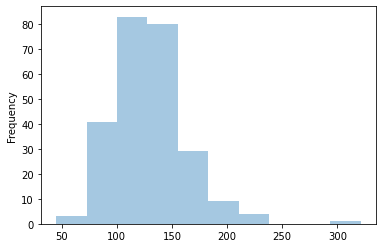

In [55]:
pandas_top250.runtimeMinutes.plot.hist(alpha=.4);

In [56]:
pandas_top250.query("runtimeMinutes > 200")

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
22,tt0031381,movie,Gone with the Wind,Gone with the Wind,0,1939,\N,238,"Drama,History,Romance",8.1,304153
43,tt1954470,movie,Gangs of Wasseypur,Gangs of Wasseypur,0,2012,\N,321,"Action,Comedy,Crime",8.2,91269
47,tt0071562,movie,The Godfather: Part II,The Godfather: Part II,0,1974,\N,202,"Crime,Drama",9.0,1199641
51,tt0087843,movie,Once Upon a Time in America,Once Upon a Time in America,0,1984,\N,229,"Crime,Drama",8.3,334313
66,tt0047478,movie,Seven Samurai,Shichinin no samurai,0,1954,\N,207,"Action,Drama",8.6,332544
68,tt0060107,movie,Andrei Rublev,Strasti po Andreyu,0,1966,\N,205,"Biography,Drama,History",8.1,51620
76,tt0167260,movie,The Lord of the Rings: The Return of the King,The Lord of the Rings: The Return of the King,0,2003,\N,201,"Action,Adventure,Drama",8.9,1732634
149,tt0052618,movie,Ben-Hur,Ben-Hur,0,1959,\N,212,"Adventure,Drama,History",8.1,230758
221,tt0056172,movie,Lawrence of Arabia,Lawrence of Arabia,0,1962,\N,228,"Adventure,Biography,Drama",8.3,282511


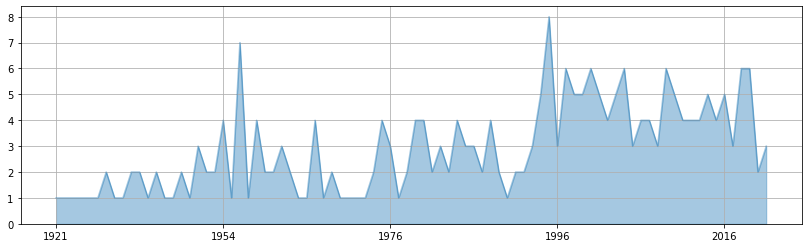

In [57]:
pandas_top250.startYear.value_counts().sort_index().plot.area(figsize=(14,4), alpha=.4, grid=True);

In [58]:
pandas_top250.nlargest(10, 'averageRating')

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
181,tt15097216,movie,Jai Bhim,Jai Bhim,0,2021,\N,164,"Crime,Drama",9.4,159853
172,tt0111161,movie,The Shawshank Redemption,The Shawshank Redemption,0,1994,\N,142,Drama,9.3,2508772
187,tt0068646,movie,The Godfather,The Godfather,0,1972,\N,175,"Crime,Drama",9.2,1728766
42,tt10872600,movie,Spider-Man: No Way Home,Spider-Man: No Way Home,0,2021,\N,148,"Action,Adventure,Fantasy",9.0,213149
47,tt0071562,movie,The Godfather: Part II,The Godfather: Part II,0,1974,\N,202,"Crime,Drama",9.0,1199641
109,tt0050083,movie,12 Angry Men,12 Angry Men,0,1957,\N,96,"Crime,Drama",9.0,740976
125,tt0468569,movie,The Dark Knight,The Dark Knight,0,2008,\N,152,"Action,Crime,Drama",9.0,2458715
34,tt0108052,movie,Schindler's List,Schindler's List,0,1993,\N,195,"Biography,Drama,History",8.9,1283265
76,tt0167260,movie,The Lord of the Rings: The Return of the King,The Lord of the Rings: The Return of the King,0,2003,\N,201,"Action,Adventure,Drama",8.9,1732634
191,tt0110912,movie,Pulp Fiction,Pulp Fiction,0,1994,\N,154,"Crime,Drama",8.9,1934923


In [59]:
pandas_top250['startYear'] = pandas_top250['startYear'].astype(int)

In [60]:
pandas_top250[pandas_top250['startYear']==pandas_top250['startYear'].min()]

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
21,tt0012349,movie,The Kid,The Kid,0,1921,\N,68,"Comedy,Drama,Family",8.3,121613


In [61]:
pandas_top250[pandas_top250['startYear']==pandas_top250['startYear'].max()]

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
42,tt10872600,movie,Spider-Man: No Way Home,Spider-Man: No Way Home,0,2021,\N,148,"Action,Adventure,Fantasy",9.0,213149
181,tt15097216,movie,Jai Bhim,Jai Bhim,0,2021,\N,164,"Crime,Drama",9.4,159853
195,tt1160419,movie,Dune,Dune: Part One,0,2021,\N,155,"Action,Adventure,Drama",8.2,397768


In [62]:
pandas_top250.query("startYear == 1995")

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
12,tt0112641,movie,Casino,Casino,0,1995,\N,178,"Crime,Drama",8.2,494205
55,tt0112471,movie,Before Sunrise,Before Sunrise,0,1995,\N,101,"Drama,Romance",8.1,290892
74,tt0113247,movie,La Haine,La haine,0,1995,\N,98,"Crime,Drama",8.1,162908
75,tt0113277,movie,Heat,Heat,0,1995,\N,170,"Action,Crime,Drama",8.2,617523
139,tt0114369,movie,Se7en,Se7en,0,1995,\N,127,"Crime,Drama,Mystery",8.6,1540586
140,tt0114814,movie,The Usual Suspects,The Usual Suspects,0,1995,\N,106,"Crime,Drama,Mystery",8.5,1039756
155,tt0112573,movie,Braveheart,Braveheart,0,1995,\N,178,"Biography,Drama,History",8.3,997628
156,tt0114709,movie,Toy Story,Toy Story,0,1995,\N,81,"Adventure,Animation,Comedy",8.3,938840


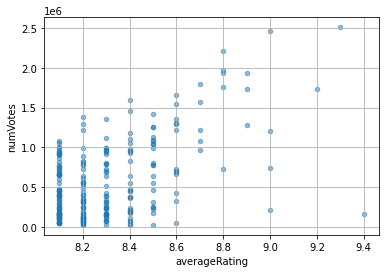

In [63]:
pandas_top250.plot.scatter(x='averageRating', y='numVotes', alpha=.5, grid=True);

In [64]:
pandas_top250.query("averageRating > 9 & numVotes > 1.5e6")

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
172,tt0111161,movie,The Shawshank Redemption,The Shawshank Redemption,0,1994,\N,142,Drama,9.3,2508772
187,tt0068646,movie,The Godfather,The Godfather,0,1972,\N,175,"Crime,Drama",9.2,1728766
